# Train a Basic Detector

In this example, we will use `torchradio` to train a detector. A detector is a simple binary classifier that reports the probability that a given family of transmitters are active. Note that detection does not fully capture `torchradio`'s core feature of backpropagation to tranmission. However, this is still a useful example to see how we can train a single aspect of a communications channel.

We start by defining some common imports.

In [1]:
from random import randint

import numpy as np
import pandas as pd
import plotly.express as px
import torch
from IPython.display import Image
from torch import nn
from tqdm import tqdm

from torchradio import Receiver, Reception, Transmitter
from torchradio.algorithm import Modem
from torchradio.env.null import RandomAWGNEnvironment

For this experiment, we define two transmitters and a detector. One transmitter will be our transmitter-of-interest, and the other is just a source of background noise.

In [2]:
transmitters = {
    "target": Transmitter(Modem("psk", 4).tx),
    "ignore": Transmitter(Modem("qam", 16).tx),
}

Let's define a trainable detection algorithm called `QPSKDetector`.

In [3]:
class QPSKDetector(nn.Module):
    """A trainable detector that uses convolutional layers to detect QPSK."""

    def __init__(self) -> None:  # noqa: D107
        super().__init__()

        self._conv = nn.Sequential(
            nn.LazyConv1d(16, 16, 5),
            nn.ReLU(),
            nn.LazyConv1d(32, 8, 3),
            nn.ReLU(),
            nn.LazyConv1d(64, 4, 1),
            nn.ReLU(),
        )

        self._ff = nn.Sequential(
            nn.LazyLinear(64),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.LazyLinear(1),
            nn.Sigmoid(),
        )

        self._flatten = nn.Flatten()

    def rx(self, signal: torch.Tensor) -> Reception:  # noqa: D102
        return {"probabilities": self.forward(signal)}

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # noqa: D102
        x = torch.stack([x.real, x.imag]).transpose(1, 0)
        x = self._flatten(self._conv(x))
        return self._ff(x)

Let's now instantiate `QPSKDetector` and add it to a receiver. Notice that we only provide the `rx` method to the `Receiver` class. The simulation only needs to know about the forward pass.

In [4]:
detection_algorithm = QPSKDetector()
receivers = {"detector": Receiver(detection_algorithm.rx)}

/home/daniel/code/torchradio/venv/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


We will use a predefined `torchradio` environment called `RandomAWGNEnvironment`. For each receiver, the transmissions will be randomly attenuated and a random amount of AWGN will be applied. The amount of AWGN per run is sampled uniformly from the bounds specified at initialization.

In [5]:
env = RandomAWGNEnvironment(0, 1)

We define a helper function `get_subset` to random select a subset of the available transmitters.

In [6]:
def get_subset() -> dict[str, Transmitter]:
    """Get a random subset of the transmitters."""
    subset = {}
    for transmitter_name, transmitter in transmitters.items():
        if randint(0, 1) == 0:  # noqa: S311
            subset[transmitter_name] = transmitter  # noqa: PERF403
    return subset

Next we define function called `train`. At each iteration, iterate over all possible transmitter subsets (including the empty set). We then penalize the receiver depending on how well it classifies the presence of the target transmitter. 

In [7]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(detection_algorithm.parameters(), lr=1e-4)

# manually specify all possible subsets
placements = [
    {},
    {"target": transmitters["target"]},
    {"ignore": transmitters["ignore"]},
    transmitters,
]


def _train(
    n_timesteps: int,
    batch_size: int,
    threshold: float = 0.5,
) -> dict[str, float]:
    optimizer.zero_grad()

    accuracies = []
    for p in placements:
        env.place(p, receivers)

        device_logs = env.simulate(n_timesteps, batch_size)
        detector_output = device_logs.rx["detector"]["probabilities"]

        # compute loss, gradient and update parameters
        label = (
            torch.ones_like(detector_output)
            if "target" in p
            else torch.zeros_like(detector_output)
        )
        loss = loss_fn(detector_output, label)
        loss.backward()  # accumulate over different subsets

        # bookkeeping
        accuracies.append(
            torch.mean(((detector_output > threshold) == label.bool()).float()).numpy(),
        )

    optimizer.step()

    return {"loss": loss.detach().numpy(), "accuracy": np.mean(accuracies)}

We can now call `_train` multiple times to train our detector.

In [8]:
# track metrics over time
losses = []
accuracies = []

n_iterations = 1000
batch_size = 10
n_timesteps = 128

for _ in tqdm(range(n_iterations)):
    train_logs = _train(n_timesteps, batch_size)
    losses.append(train_logs["loss"])
    accuracies.append(train_logs["accuracy"])

100%|██████████| 1000/1000 [01:27<00:00, 11.44it/s]


We can plot the losses to observe improvement over time.

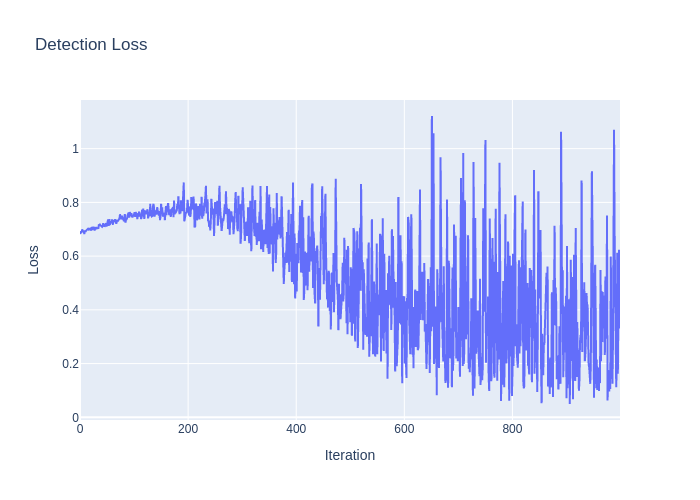

In [9]:
fig = px.line(
    pd.DataFrame({"loss": losses, "iteration": list(range(len(losses)))}),
    x="iteration",
    y="loss",
    log_y=False,
    title="Detection Loss",
    labels={"iteration": "Iteration", "loss": "Loss"},
)
Image(fig.to_image(format="png"))

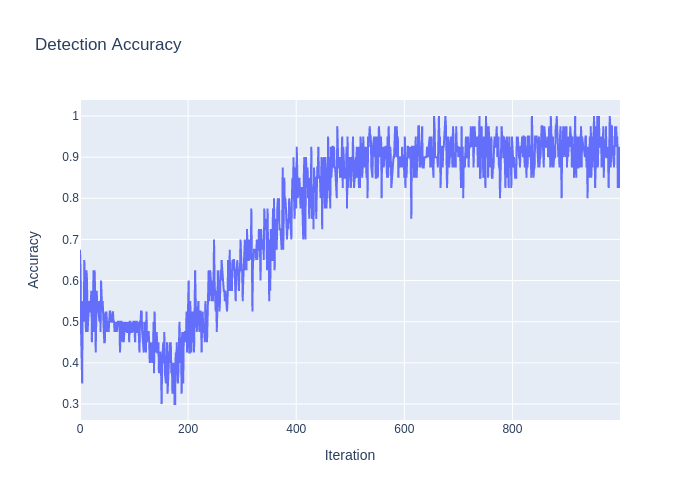

In [10]:
fig = px.line(
    pd.DataFrame({"accuracy": accuracies, "iteration": list(range(len(accuracies)))}),
    x="iteration",
    y="accuracy",
    title="Detection Accuracy",
    labels={"iteration": "Iteration", "accuracy": "Accuracy"},
)
Image(fig.to_image(format="png"))